In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
import scaleogram as scg 
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
from mat4py import loadmat
from scipy.fftpack import fft
import wfdb
import re

# Read source and create 2 lists and a dataset of annotations
ecg_data : data  
ecg_labels : labels quality class (1, 2 or 3; 0 means the quality was not annotated in this segment) 
dataset annotations : dataannall
Source : https://physionet.org/content/butqdb/1.0.0/

In [24]:
# source wfdb
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
record_list = wfdb.get_record_list('butqdb')
dataannall = pd.DataFrame(columns=header_list)
ecg_data=[]
ecg_labels=[]
for rcd in record_list:
    if re.search(r'ECG$', rcd):
        record_name = f"../aura-data/{rcd}"
        print(record_name)
        record_csv = f"../aura-data/{rcd.replace('ECG','ANN')}.csv"
        dataann = pd.read_csv(record_csv, names=header_list)
        dataannall = pd.concat([dataannall,dataann.assign(record=rcd.split('/')[0])], ignore_index=True)
        dataann_nan_class = dataann[dataann["class"].notnull() & dataann["start"].notnull() & dataann["end"].notnull() ]
        for i in dataann_nan_class.index:
            record = wfdb.rdrecord(record_name, sampfrom=int(dataann_nan_class.start[i]), sampto=int(dataann_nan_class.end[i]))
            ecg_data.append(record.adc()[:5000,0].tolist())
            ecg_labels.append(int(dataann_nan_class["class"][i]))
#Add columns to dataset
dataannall['signal_length']=dataannall['end'] - dataannall['start']

../aura-data/100001/100001_ECG
../aura-data/100002/100002_ECG
../aura-data/103001/103001_ECG
../aura-data/103002/103002_ECG
../aura-data/103003/103003_ECG
../aura-data/104001/104001_ECG
../aura-data/105001/105001_ECG
../aura-data/111001/111001_ECG
../aura-data/113001/113001_ECG
../aura-data/114001/114001_ECG
../aura-data/115001/115001_ECG
../aura-data/118001/118001_ECG
../aura-data/121001/121001_ECG
../aura-data/122001/122001_ECG
../aura-data/123001/123001_ECG
../aura-data/124001/124001_ECG
../aura-data/125001/125001_ECG
../aura-data/126001/126001_ECG


In [26]:
dataannall.head()

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,record,signal_length
0,1.0,198867.0,2.0,1.0,19525.0,1.0,1,7047,2,1.0,7047.0,2.0,100001,7046.0
1,198868.0,320282.0,1.0,19526.0,28694.0,2.0,7048,17209,1,7048.0,17209.0,1.0,100001,10161.0
2,320283.0,373109.0,2.0,28695.0,32739.0,1.0,17210,28390,2,17210.0,28694.0,2.0,100001,11484.0
3,373110.0,2197974.0,1.0,32740.0,96699.0,2.0,28391,32653,1,28695.0,32653.0,1.0,100001,3958.0
4,2197975.0,2582746.0,2.0,96700.0,110564.0,1.0,32654,71061,2,32654.0,112474.0,2.0,100001,79820.0


In [27]:
dataannall.describe()

,start1,end1,class1,start2,end2,class2,start,end,class,signal_length
count,2.077000e+03,2.077000e+03,2077.000000,4.367000e+03,4.367000e+03,4367.000000,7.154000e+03,7.154000e+03,7154.000000,7.154000e+03
mean,5.735963e+07,5.818940e+07,1.747232,5.943268e+07,5.982732e+07,1.569728,5.601431e+07,5.625521e+07,1.604417,2.409030e+05
std,3.224540e+07,3.202623e+07,0.732633,3.053024e+07,3.039626e+07,0.603570,2.802337e+07,2.796447e+07,0.609641,2.530322e+06
min,1.000000e+00,1.988670e+05,0.000000,1.000000e+00,1.952500e+04,0.000000,1.000000e+00,7.047000e+03,0.000000,3.020000e+02
25%,2.961534e+07,2.971780e+07,1.000000,3.194364e+07,3.252046e+07,1.000000,3.405290e+07,3.411941e+07,1.000000,2.264250e+03
50%,5.680874e+07,5.760000e+07,2.000000,5.793045e+07,5.794909e+07,2.000000,5.507225e+07,5.570303e+07,2.000000,5.853000e+03
75%,7.522262e+07,7.668958e+07,2.000000,7.695822e+07,7.723874e+07,2.000000,6.858724e+07,6.945778e+07,2.000000,1.982150e+04
max,1.391201e+08,1.391470e+08,3.000000,1.391468e+08,1.391470e+08,3.000000,1.391201e+08,1.391470e+08,3.000000,7.464800e+07


In [17]:
dataannall.sort_values(by=['signal_length']).head(10)

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,signal_length
2164,29830121.0,29843829.0,2.0,29833497.0,29842799.0,2.0,29041071,29041373,2,29041071.0,29041373.0,2.0,302.0
6902,NaN,NaN,NaN,NaN,NaN,NaN,22772239,22806837,1,42187296.0,42187599.0,2.0,303.0
14215,57653762.0,57664665.0,1.0,29052794.0,29058124.0,1.0,28815944,28816279,1,28871845.0,28872149.0,1.0,304.0
1961,29896114.0,29909814.0,1.0,29430978.0,29432026.0,2.0,29201971,29203041,2,29367658.0,29367979.0,2.0,321.0
14982,NaN,NaN,NaN,65811759.0,65824014.0,3.0,58413007,58414129,1,65500416.0,65500737.0,2.0,321.0
15543,57711177.0,57779132.0,1.0,29622202.0,29624040.0,1.0,28902711,29014385,1,29637312.0,29637634.0,1.0,322.0
2087,NaN,NaN,NaN,NaN,NaN,NaN,29712177,29713943,2,29974330.0,29974654.0,2.0,324.0
1347,NaN,NaN,NaN,29422321.0,29423807.0,2.0,2.95904e+07,2.95909e+07,2,29583767.0,29584095.0,2.0,328.0
15582,NaN,NaN,NaN,57917191.0,57917810.0,2.0,57655491,57655835,2,58410626.0,58410956.0,2.0,330.0
14943,NaN,NaN,NaN,65570247.0,65579982.0,1.0,58189527,58190516,2,65289466.0,65289798.0,2.0,332.0


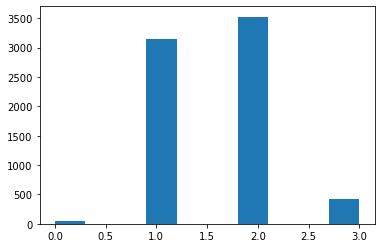

In [29]:
plt.hist(dataannall['class'], bins=10);
plt.show()

# Scaleogram

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


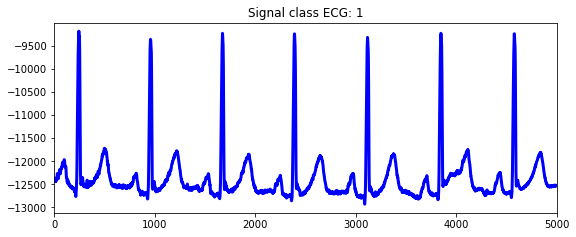

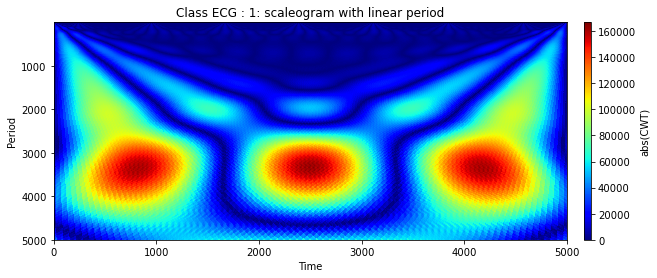

In [32]:
# choose default wavelet function 
scg.set_default_wavelet('morl')

nn = 33
signal_length = 5000
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(ecg_data[nn]),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, ecg_data[nn], linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title(f"Signal class ECG: {ecg_labels[nn]}")

# the scaleogram
scg.cws(ecg_data[nn][:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title=f"Class ECG {ecg_labels[nn]}: scaleogram with linear period"); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")